In [1]:
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

class RLB:
    
    def __init__(self,df,target_name):
        self.X = df.drop(target_name,axis=1)
        self.y = df[target_name]
        self.df = df
        self.tname = target_name

    
    def fitted(self):
        X = sm.add_constant(self.X)
        self.model = sm.OLS(self.y, X).fit()
        self.y_pred = self.model.predict(X)
        self.error = self.y_pred - self.y
        return self.model
    
    def Wfitted(self):
        X = sm.add_constant(self.X)
        self.W = (1/self.error)**2
        self.model = sm.WLS(self.y,X,weights=(self.W)).fit()
        self.Wy_pred = self.model.predict(X)
        self.Werror = self.Wy_pred - self.y
        return self.model
    
    def multicol(self): 
        result = {self.X.columns[i]:variance_inflation_factor(self.X,i) for i in range(len(self.X.columns))}
        return pd.Series(result)
    
    def tabelPencilan(self):        
        return self.model.get_influence().summary_frame()
    
    def errorDist(self,weight=False):
        if not weight:
            stats.probplot(self.error, dist="norm", plot=plt)
            plt.title("Visualisasi Kenormalan Sisaan (QQPLOT)")
        else:
            stats.probplot(self.Werror, dist="norm", plot=plt)
            plt.title("Visualisasi Kenormalan Sisaan (QQPLOT & Weighted)")
    
    def cekHomogenHarapan(self,weight=False):
        if not weight:
            y_pred = np.array(self.y_pred)
            error = np.array(self.error)

            fig, ax = plt.subplots()
            ax.hlines(y=0,xmin=y_pred.min(),xmax=y_pred.max(),color="red")
            ax.plot(y_pred,error,"o")
            plt.title("Visualisasi residuals vs yduga")
            plt.show()
        else:
            W = np.diag(np.sqrt(self.W))
            Wy_pred = np.array(W @ self.Wy_pred)
            Werror = np.array(W @ self.Werror)

            fig, ax = plt.subplots()
            ax.hlines(y=0,xmin=Wy_pred.min(),xmax=Wy_pred.max(),color="red")
            ax.plot(Wy_pred,Werror,"o")
            plt.title("Visualisasi residuals vs yduga (Weighted)")
            plt.show()
            
        
    def resStdOutlier(self,alpha=0.05):
        tabel = self.tabelPencilan()
        ztabel = stats.norm.ppf(q=1-(alpha/2))
        idx = tabel.loc[np.abs(tabel["standard_resid"]) > ztabel].index
        return idx
    
    def scPlot(self,nama_kolom):
#         m = 2
#         n = int(np.ceil(len(nama_kolom)/m))
        colors_col = ["red","green","blue"]
        n = len(nama_kolom)
        fig, axes = plt.subplots(nrows=n,ncols=1,figsize=(10,8*n) )
        fig.tight_layout(pad=5.0)
        iterasi = 0
        for kolom,ax in zip(nama_kolom,axes.flatten()):
            korelasi = np.corrcoef(df[kolom],df[self.tname])[0][1]
            ax.annotate("r (corr) = {:.3f}".format(korelasi),(df[kolom].min(),df[self.tname].max()),size=20)
            ax.scatter(self.df[kolom],self.df[self.tname],color=colors_col[iterasi%3])
            ax.set_xlabel(f"{kolom}",fontsize=15)
            ax.set_ylabel(f"{self.tname}",fontsize=15)
            iterasi += 1

In [3]:
df = pd.read_csv("startup.csv")
df = df.drop(["State"],axis=1)
df.columns = pd.Series(df.columns).map({"R&D Spend" : "Research","Administration" : "Admin","Marketing Spend" : "Marketing", "Profit" : "Profit"})
df.head()

,Research,Admin,Marketing,Profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Research   50 non-null     float64
 1   Admin      50 non-null     float64
 2   Marketing  50 non-null     float64
 3   Profit     50 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


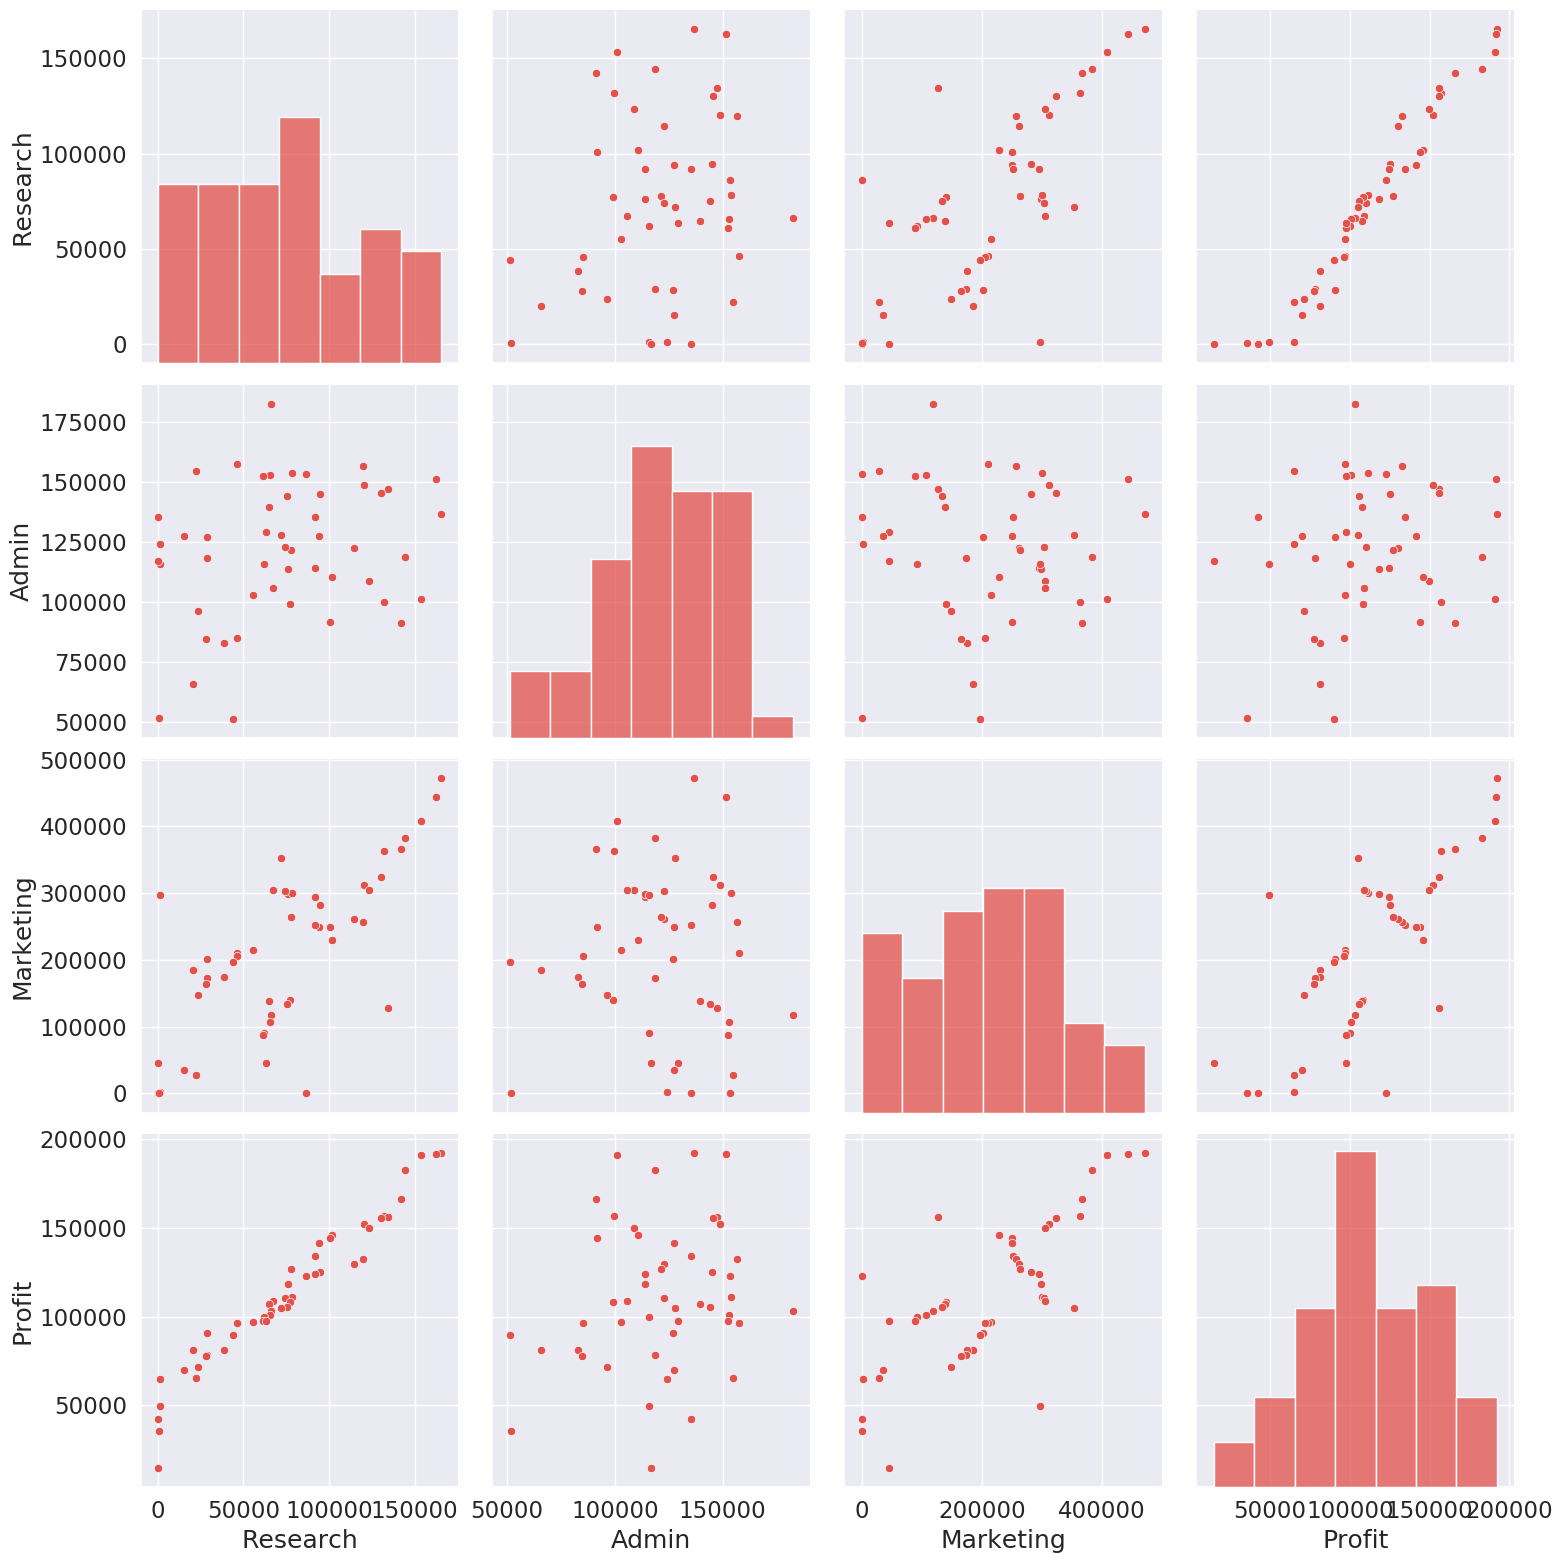

In [5]:
sns.pairplot(df,size=4)

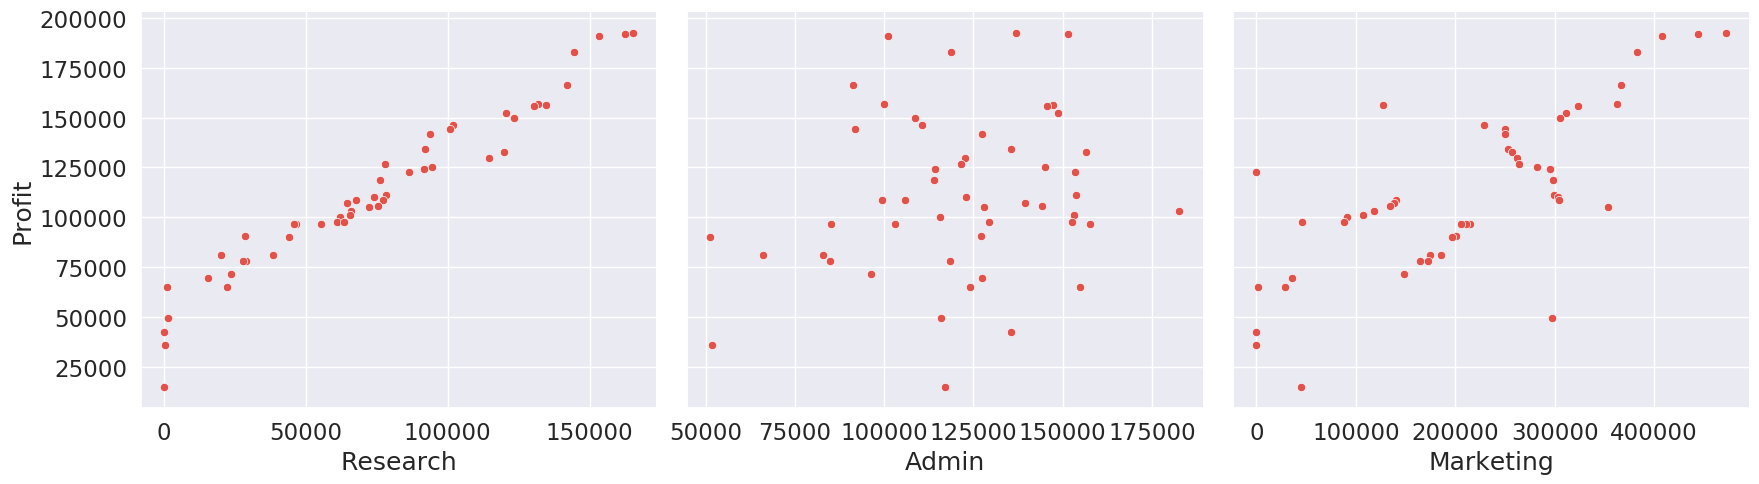

In [6]:
sns.pairplot(df,x_vars=["Research","Admin","Marketing"],y_vars="Profit",size=5,aspect=1.2)

In [7]:
first_rgs = RLB(df,"Profit")
first_model = first_rgs.fitted()
print(first_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Mon, 01 May 2023   Prob (F-statistic):           4.53e-30
Time:                        18:12:26   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.012e+04   6572.353      7.626      0.0

# Eksplorasi dan Uji Asumsi

## Asumsi rataan (nilai harapan) galat di sekitar 0

### Menggunakan Visualisasi error vs yduga

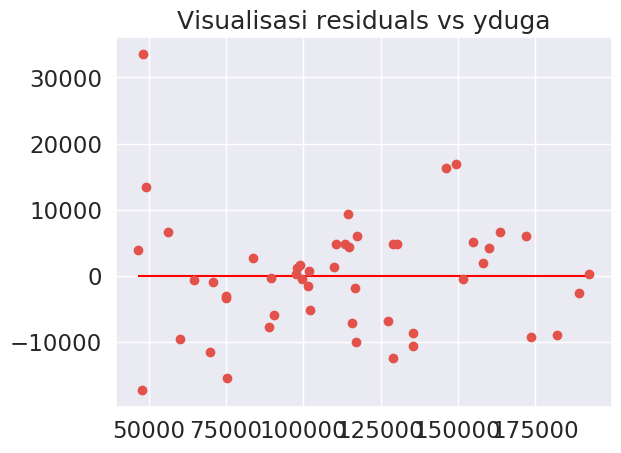

In [8]:
first_rgs.cekHomogenHarapan()

### Hasil kalkulasi rataan galat

In [9]:
X = df[["Research","Admin","Marketing"]].copy()
y = df["Profit"].copy()
X = sm.add_constant(X)
y_pred = first_model.predict(X)
error = y_pred-y
print(np.mean(error))

5.486072041094303e-11


#### rataan galat mendekati 0

## Asumsi galat menyebar normal

### Visualisasi QQplot dari galat

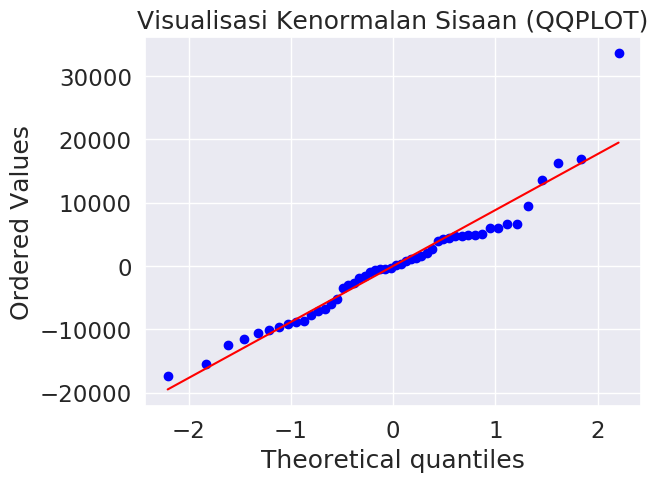

In [10]:
first_rgs.errorDist()

### Visualisasi Sebaran (Histogram) dari galat

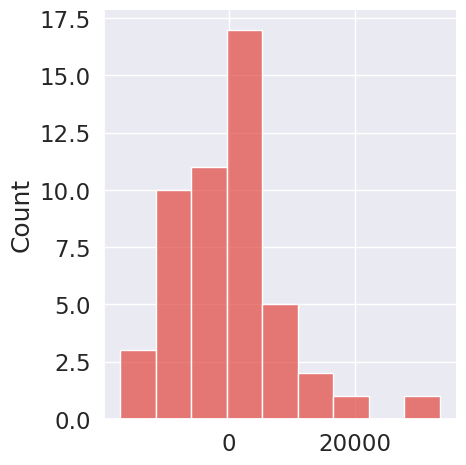

In [11]:
sns.displot(error)

### Menggunakan Uji Shapiro-Wilk

#### H0 : sample berasal dari distribusi normal (alpha = 0.05)
#### H1 : sample tidak berasal dari distribusi normal (alpha = 0.05)

In [12]:
def normalTestShapiroWilk(sample,tol=0.05):
    test = stats.shapiro(error)
    if (test.pvalue < tol):
        print("Galat tidak menyebar normal secara signifikan dengan alfa 5 persen")
    else:
        print("Galat menyebar normal secara signifikan dengan alfa 5 persen")
        
normalTestShapiroWilk(error)

Galat tidak menyebar normal secara signifikan dengan alfa 5 persen


## Asumsi Ragam Galat Homogen

### Menggunakan Visualisasi error vs yduga

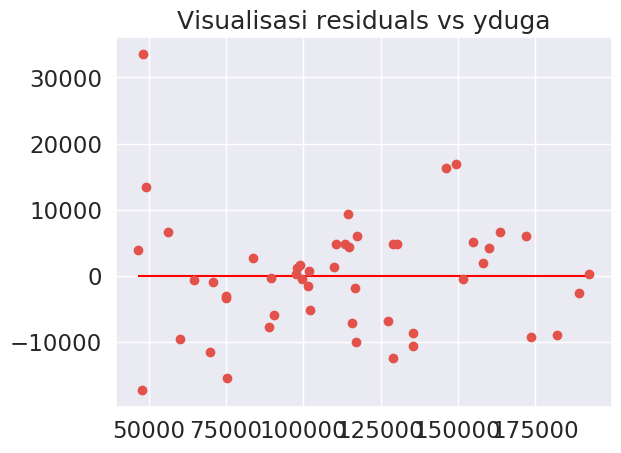

In [13]:
first_rgs.cekHomogenHarapan()

### Menggunakan Uji Breush-Pagan dan Uji White

#### H0 : ragam sisaan homogen (alpha = 0.05)
#### H1 : ragam sisaan tidak homogen (alpha = 0.05)

In [14]:
from statsmodels.stats import diagnostic

def ujiSisaanHomogen(sisaan,X,tol=0.05):
    labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
    bp_test = diagnostic.het_breuschpagan(sisaan,X)
    nilai = dict(zip(labels,bp_test))
    if nilai["F-Test p-value"] < tol:
        print(f"ragam sisaan tidak homogen secara signifikan dengan alfa {tol} (Breush-Pagan Test)")
    else:
        print(f"ragam sisaan homogen secara signifikan dengan alfa {tol} (Breush-Pagan Test)")
    print(f"p-value = {nilai['F-Test p-value']}")
    
    for i in range(1): print()
    
    white_test = diagnostic.het_white(sisaan,X)
    nilai = dict(zip(labels,white_test))
    if nilai["F-Test p-value"] < tol:
        print(f"ragam sisaan tidak homogen secara signifikan dengan alfa {tol} (White Test)")
    else:
        print(f"ragam sisaan homogen secara signifikan dengan alfa {tol} (White Test)")
    print(f"p-value = {nilai['F-Test p-value']}")
    
        
ujiSisaanHomogen(error,X)

ragam sisaan homogen secara signifikan dengan alfa 0.05 (Breush-Pagan Test)
p-value = 0.39170223742617594

ragam sisaan homogen secara signifikan dengan alfa 0.05 (White Test)
p-value = 0.1946453621805264


## Asumsi Multikolinearitas

In [15]:
def multikolCek(X):
    result = {X.columns[i]:variance_inflation_factor(X,i) for i in range(len(X.columns))}
    VIFS = list(result.values())
    cek = all([VIF < 10 for VIF in VIFS])
    if cek:
        print("Semua nilai VIF bernilai kurang dari 10")
        print("Tidak ada indikasi terjadinya multikolinearitas")
    else:
        cek = any([VIF > 100 for VIF in VIFS])
        if cek:
            print("Ada indikasi kuat terjadinya multikolinearitas (VIF > 100)")
        else:
            print("Ada kemungkinan terjadinya multikolinearitas (10 < VIF < 100)")
    return pd.Series(result)

X = df.drop("Profit",axis=1)
dataVIF =  multikolCek(X)
dataVIF

Semua nilai VIF bernilai kurang dari 10
Tidak ada indikasi terjadinya multikolinearitas


Research     8.384571
Admin        4.026406
Marketing    7.593984
dtype: float64

## Asumsi Autokorrelasi (Durbin Watson)

In [16]:
from statsmodels.stats.stattools import durbin_watson

def cekDurbinWatson(error):
    val = durbin_watson(error)
    if val < 1.5:
        print("Ada indikasi positif autokorelasi")
    elif val > 2.5:
        print("Ada indikasi negatif autokorelasi")
    else:
        print("Tidak ada indikasi autokorelasi")
    
    return val

val = cekDurbinWatson(error)
print(f"val = {val}")

Ada indikasi positif autokorelasi
val = 1.2817662007267303


## Memeriksa pencilan

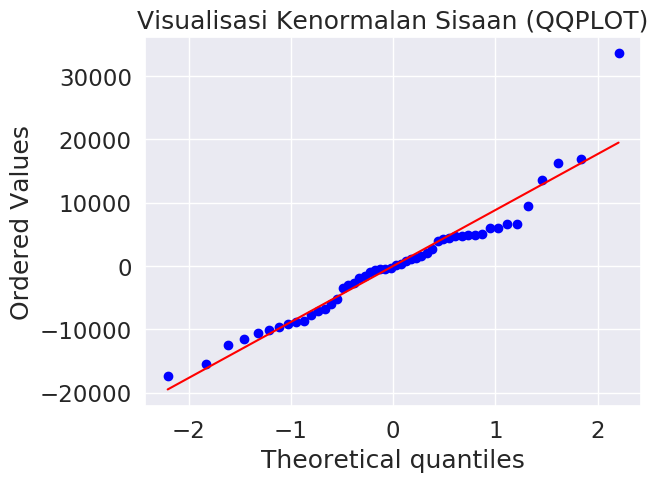

In [17]:
first_rgs.errorDist()

#### Berdasarkan visualisasi diatas, terdapat pencilan pada sisaan. akan dilakukan pembuangan pencilan tersebut menggunakan standard residual lalu mencoba membandingkan rsquare setelah pencilan dibuang dengan sebelum pencilan dibuang

In [18]:
indeks_pencilan = first_rgs.resStdOutlier()
df_tidak_ada_pencilan = df.drop(49,axis=0).copy()
second_reg = RLB(df_tidak_ada_pencilan,"Profit")
second_model = second_reg.fitted()

In [19]:
print("Sebelum pencilan dibuang")
print()
print(first_model.summary())

for i in range(5) : print()

print("Setelah pencilan dibuang")
print()
print(second_model.summary())

for i in range(5): print()

print("Sebelum pencilan dibuang")
print("rsquared\t: %0.3f\nrsquared-adj\t: %0.3f" % (first_model.rsquared,first_model.rsquared_adj))
print()
print("Setelah pencilan dibuang")
print("rsquared\t: %0.3f\nrsquared-adj\t: %0.3f" % (second_model.rsquared,second_model.rsquared_adj))

Sebelum pencilan dibuang

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Mon, 01 May 2023   Prob (F-statistic):           4.53e-30
Time:                        18:12:28   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.012e+04   65

#### Ketika pencilan dibuang, terlihat bahwa rsquared dan rsquared-adj mengalami peningkatan sekitar 1 %

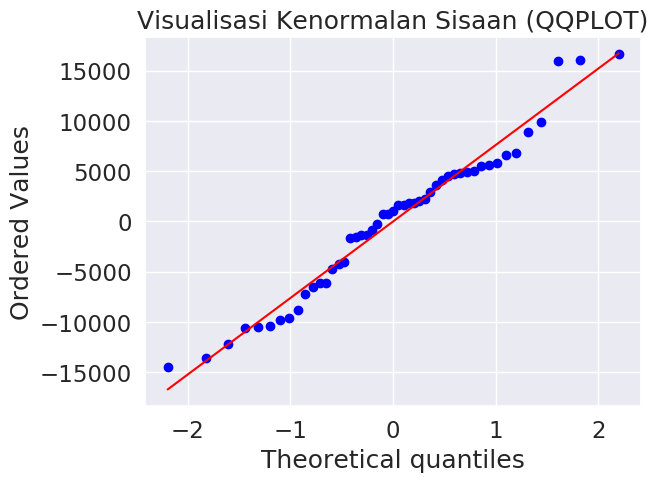

In [20]:
second_reg.errorDist()

# Visualisasi sebelum melakukan transformasi

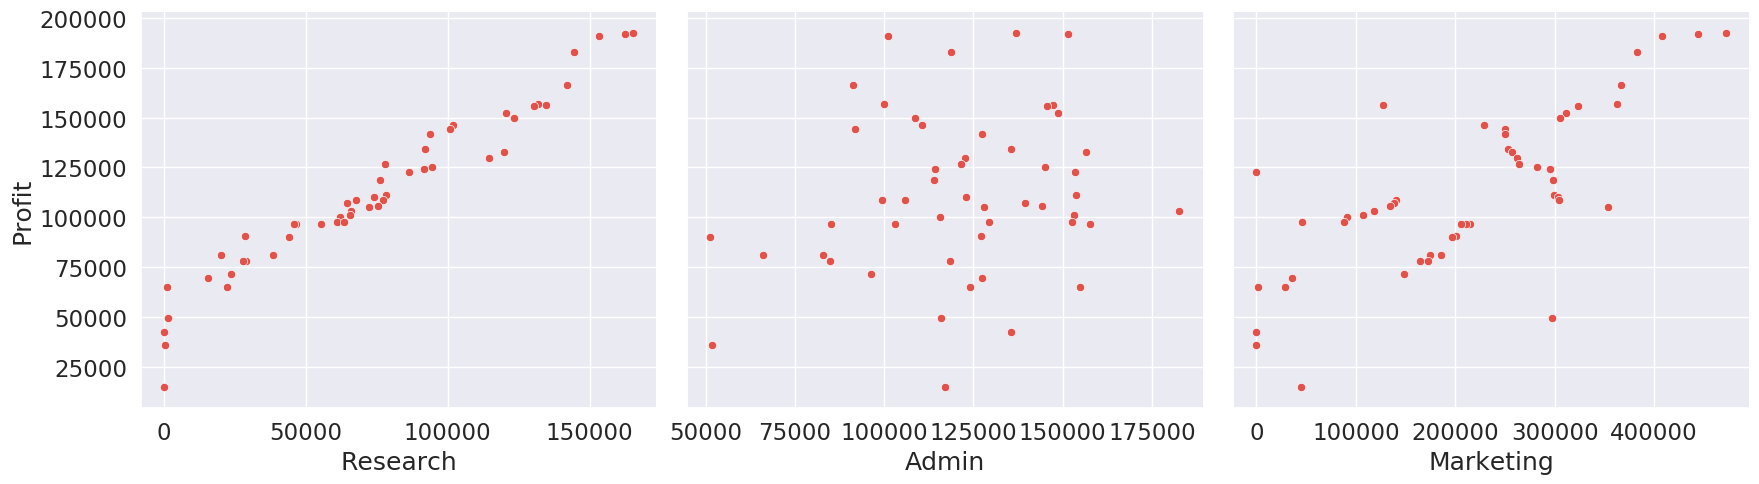

In [21]:
sns.pairplot(df,x_vars=["Research","Admin","Marketing"],y_vars="Profit",size=5,aspect=1.2)

#### Pada ketiga plot diatas, variable Research terlihat berhubungan linier kuat dengan variable Profit sehingga tidak akan dilakukan transformasi pada variable tersebut. Sementara variable Admin terlihat tidak memiliki pola dalam bentuk apapun itu sehingga tidak dilakukan transformasi juga (ada kemungkinan kami buang, tetapi menggunakan stepwise selection). Lalu variable marketing, cenderung memiliki hubungan linear walaupun tidak sekuat variable Research.

## Korelasi masing - masing independent terhadap dependent variables

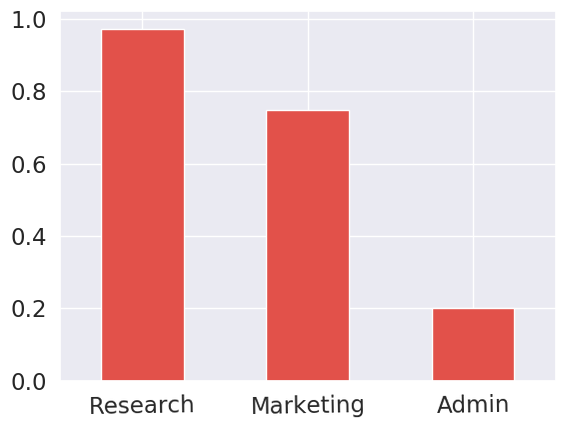

In [22]:
korelasi = df.corr().loc["Profit"].sort_values(ascending=False).drop("Profit")
korelasi.plot.bar(rot=1)

# Menggunakan Weighted Least Square dengan Weightnya adalah kuadrat dari galat

In [23]:
weight_model = second_reg.Wfitted()
print(weight_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.996
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3983.
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.43e-54
Time:                        18:12:31   Log-Likelihood:                -474.67
No. Observations:                  49   AIC:                             957.3
Df Residuals:                      45   BIC:                             964.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.973e+04   1066.644     46.623      0.0

#### Rsquared dan Rsquared-adj meningkat sekitar 3 % ketika menggunakan weighted least square

# Mencoba semua kemungkinan kombinasi independent variable untuk menentukan model terbaik

## (Sebelum membuang pencilan)

In [24]:
predictor_col = df.columns[:-1]
for i in range(1,8):
    bitmask = bin(i)[2:].zfill(3)
    pos_cols = []
    for bit,col in zip(bitmask,predictor_col):
        if bit == "1":
            pos_cols.append(col)
    pos_cols.append("Profit")
    dftry = df[pos_cols].copy()
    reg = RLB(dftry,"Profit")
    model = reg.fitted()
    ringkasan = model.summary()
    try:
        modelw = reg.Wfitted()
        ringkasan = modelw.summary()
        print("INI WLS")
    except:
        print("INI OLS")
        pass
    print(f"Kemungkinan {i}")
    print("Variabel Predictors\t: ",end="")
    print(*pos_cols[:-1],sep=",")
    print()
    print(ringkasan)
    print()
    if len(pos_cols) > 2:
        multikol = reg.multicol()
        print("Identifikasi Terjadinya Multikolinear ...")
        for idx in multikol.index:
            print(idx,multikol[idx],sep=" : ")
    print("\n"*3)

INI WLS
Kemungkinan 1
Variabel Predictors	: Marketing

                            WLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.967
Model:                            WLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1402.
Date:                Mon, 01 May 2023   Prob (F-statistic):           3.50e-37
Time:                        18:12:31   Log-Likelihood:                -553.69
No. Observations:                  50   AIC:                             1111.
Df Residuals:                      48   BIC:                             1115.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

INI WLS
Kemungkinan 7
Variabel Predictors	: Research,Admin,Marketing

                            WLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.875e+04
Date:                Mon, 01 May 2023   Prob (F-statistic):           3.00e-78
Time:                        18:12:31   Log-Likelihood:                -482.49
No. Observations:                  50   AIC:                             973.0
Df Residuals:                      46   BIC:                             980.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

## (sesudah membuang pencilan)

In [25]:
predictor_col = df_tidak_ada_pencilan.columns[:-1]
for i in range(1,8):
    bitmask = bin(i)[2:].zfill(3)
    pos_cols = []
    for bit,col in zip(bitmask,predictor_col):
        if bit == "1":
            pos_cols.append(col)
    pos_cols.append("Profit")
    dftry = df_tidak_ada_pencilan[pos_cols].copy()
    reg = RLB(dftry,"Profit")
    model = reg.fitted()
    ringkasan = model.summary()
    try:
        modelw = reg.Wfitted()
        ringkasan = modelw.summary()
        print("INI WLS")
    except:
        print("INI OLS")
        pass
    print(f"Kemungkinan {i}")
    print("Variabel Predictors\t: ",end="")
    print(*pos_cols[:-1],sep=",")
    print()
    print(ringkasan)
    print()
    if len(pos_cols) > 2:
        multikol = reg.multicol()
        print("Identifikasi Terjadinya Multikolinear ...")
        for idx in multikol.index:
            print(idx,multikol[idx],sep=" : ")
    print("\n"*3)

INI WLS
Kemungkinan 1
Variabel Predictors	: Marketing

                            WLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.983
Model:                            WLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2716.
Date:                Mon, 01 May 2023   Prob (F-statistic):           3.09e-43
Time:                        18:12:31   Log-Likelihood:                -540.35
No. Observations:                  49   AIC:                             1085.
Df Residuals:                      47   BIC:                             1088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

Identifikasi Terjadinya Multikolinear ...
Research : 3.9950477550897636
Admin : 3.9950477550897636




INI WLS
Kemungkinan 7
Variabel Predictors	: Research,Admin,Marketing

                            WLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.996
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3983.
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.43e-54
Time:                        18:12:31   Log-Likelihood:                -474.67
No. Observations:                  49   AIC:                             957.3
Df Residuals:                      45   BIC:                             964.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err     

#### karena banyaknya variabel independent ada 3 maka banyaknya kemungkinan model adalah 2^3 -1 yaitu 7 kemungkinan (tanpa predictor tidak termasuk). lalu kami mencoba WLS ketika sebelum pencilan dibuang dan setelah pencilan dibuang.

#### didapatkan model terbaik adalah ketika menggunakan WLS sebelum pencilan dibuang dengan variable independentnya adalah Research dan Marketing dengan r-squared = 1